In [1]:
### Preliminaries ###

import jax.numpy as jnp
import jax
import os
import trimesh
import b3d
from b3d import Pose
import rerun as rr
import genjax
from tqdm import tqdm
import demos.differentiable_renderer.likelihood_debugging.demo_utils as du
import demos.differentiable_renderer.likelihood_debugging.model as m
import demos.differentiable_renderer.likelihood_debugging.likelihoods as l
import b3d.differentiable_renderer as r
import matplotlib.pyplot as plt
import numpy as np

# import viser
# server = viser.ViserServer()

# server.add_mesh_simple(
#     name="/patch",
#     vertices=np.array(patch_vertices_P),
#     faces=np.array(patch_faces),
#     # color=np.array(patch_vertex_colors),
#     opacity=0.3
# )



In [8]:
import importlib
importlib.reload(du)

<module 'demos.differentiable_renderer.likelihood_debugging.demo_utils' from '/home/georgematheos/b3d/demos/differentiable_renderer/likelihood_debugging/demo_utils.py'>

In [9]:

### Preliminaries ###
(
    renderer,
    (observed_rgbds, gt_rots),
    ((patch_vertices_P, patch_faces, patch_vertex_colors), X_WP),
    X_WC
) = du.get_renderer_boxdata_and_patch()


# vetex_colors_with_alpha = jnp.concatenate([patch_vertex_colors, 0.3*jnp.ones((patch_vertex_colors.shape[0], 1))], axis=1)
# import trimesh
# tm = trimesh.Trimesh(
#     vertices = patch_vertices_P,
#     faces = patch_faces,
#     vertex_colors = np.array(vetex_colors_with_alpha)
# )
# server.add_mesh_trimesh(
#     name="/patch",
#     mesh=tm
# )

hyperparams = r.DifferentiableRendererHyperparams(
    3, 1e-5, 1e-2, -1
)

depth_scale = 0.01
mindepth = -1.0
maxdepth = 2.0
likelihood = l.ArgMap(
    l.ImageDistFromPixelDist(
        l.mixture_of_uniform_and_multi_uniformrgb_laplacedepth,
        [True, True, False, False, False]
    ),
    lambda weights, rgbds: ( renderer.height, renderer.width,
                            weights, rgbds, depth_scale, mindepth, maxdepth )
)

model = m.single_object_model_factory(
    renderer,
    likelihood,
    hyperparams
)

key = jax.random.PRNGKey(0)
trace, weight = model.importance(
    key,
    genjax.choice_map({
        "pose": X_WP,
        "camera_pose": X_WC,
        "observed_rgbd": observed_rgbds[0]
    }),
    (patch_vertices_P, patch_faces, patch_vertex_colors, ())
)

rr.init("test")
rr.connect("127.0.0.1:8812")
m.rr_log_trace(trace, renderer)


Pose(position=Array([0., 0., 0.], dtype=float32), quaternion=Rotation(quat=Array([0.        , 0.        , 0.80421466, 0.59433895], dtype=float32)))

Pose(position=Array([0., 0., 0.], dtype=float32), quaternion=Array([ 0.        ,  0.        ,  0.80421466, -0.59433895], dtype=float32))

Pose(position=Array([ 0.05982581, -0.01924825,  0.07019208], dtype=float32), quaternion=Array([ 0.3645516 , -0.60588956,  0.17065172,  0.68620557], dtype=float32))

In [3]:

### Generate image samples ###

def generate_image(key):
    trace, weight = model.importance(
        key,
        genjax.choice_map({ "pose": X_WP, "camera_pose": X_WC }),
        (patch_vertices_P, patch_faces, patch_vertex_colors, ())
    )
    return trace.get_retval()[0]
images = jax.vmap(generate_image)(jax.random.split(key, 100))
for i, image in enumerate(images):
    rr.set_time_sequence("image_sample", i)
    rr.log(f"/image_sample/rgb", rr.Image(image[:, :, :3]))
    rr.log(f"/image_sample/depth", rr.DepthImage(image[:, :, 3]))



In [4]:
### Grid over positions and show samples ###
# @jax.jit
def importance_from_depth(depth):
    pos = jnp.array([depth, X_WP._position[1], X_WP._position[2]])
    pose = Pose(pos, X_WP._quaternion)
    trace, weight = model.importance(
        key,
        genjax.choice_map({
            "pose": pose,
            "camera_pose": X_WC,
            "observed_rgbd": observed_rgbds[0]
        }),
        (patch_vertices_P, patch_faces, patch_vertex_colors, ())
    )
    return trace, weight

# depths = jnp.linspace(0.01, 0.15 1000)
# scores = jnp.stack([get_score(d) for d in depths])
# plt.plot(depths, scores)

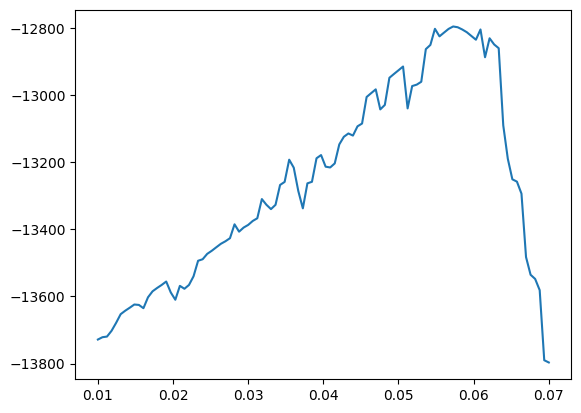

In [ ]:
depths = jnp.linspace(0.01, 0.07, 100)
scores = []
for (i, depth) in enumerate(depths):
    trace, weight = importance_from_depth(depth)
    scores.append(weight)
    rr.set_time_sequence("depth", i)
    m.rr_log_trace(trace, renderer)
    rr.log("weight11", rr.Scalar(weight))
    rr.log("value", rr.Scalar(depth))

plt.plot(depths, scores)

TypeError: Rotation.from_euler() missing 1 required positional argument: 'angles'

In [70]:
trace, weight = model.importance(
    key,
    genjax.choice_map({
        "pose": pose,
        "camera_pose": X_WC,
        "observed_rgbd": observed_rgbds[0]
    }),
    (patch_vertices_P, patch_faces, patch_vertex_colors, ())
)

In [71]:
trace["pose"].apply(trace.get_args()[0])

Array([[ 0.04538996, -0.01814368,  0.05567744],
       [ 0.04538996, -0.02101511,  0.05567744],
       [ 0.04538996, -0.01814368,  0.05854885],
       ...,
       [ 0.07403742, -0.0213117 ,  0.08142591],
       [ 0.07403742, -0.01843569,  0.08430192],
       [ 0.07403742, -0.0213117 ,  0.08430192]], dtype=float32)

In [5]:
### Grid over positions and show samples ###
@jax.jit
def importance_from_rot(rot):
    r = X_WP.rot * b3d.Rot.from_euler("x", rot, degrees=False)
    pose = Pose.from_vec(jnp.concatenate([
        X_WP._position, r.as_quat()
    ]))
    trace, weight = model.importance(
        key,
        genjax.choice_map({
            "pose": pose,
            "camera_pose": X_WC,
            "observed_rgbd": observed_rgbds[0]
        }),
        (patch_vertices_P, patch_faces, patch_vertex_colors, ())
    )
    return trace, weight

# depths = jnp.linspace(0.01, 0.15 1000)
# scores = jnp.stack([get_score(d) for d in depths])
# plt.plot(depths, scores)

In [94]:
for i in range(10):
    trace, weight = importance_from_rot(jnp.pi * 0.1 * i)

    rr.set_time_sequence("rot", i)
    m.rr_log_trace(trace, renderer)
    rr.log("weight", rr.Scalar(weight))
    rr.log("value", rr.Scalar(depth))

In [10]:
### Grid over positions and show samples ###
@jax.jit
def importance_from_rot_2(true_pose, new_y_rot):
    r = true_pose.rot * b3d.Rot.from_euler("y", new_y_rot, degrees=False)
    pose = Pose.from_vec(jnp.concatenate([
        true_pose._position, r.as_quat()
    ]))
    trace, weight = model.importance(
        key,
        genjax.choice_map({
            "pose": pose,
            "camera_pose": X_WC,
            "observed_rgbd": observed_rgbds[20]
        }),
        (patch_vertices_P, patch_faces, patch_vertex_colors, ())
    )
    return trace, weight

# depths = jnp.linspace(0.01, 0.15 1000)
# scores = jnp.stack([get_score(d) for d in depths])
# plt.plot(depths, scores)

In [11]:
# W = world; C = Camera; P0 = patch at time 0; P20 = patch at time 20; B20 = Box
R_W_B0 = b3d.Rot.from_matrix(gt_rots[0])
R_W_B20 = b3d.Rot.from_matrix(gt_rots[20])

X_W_B0 = Pose.from_quat(R_W_B0.as_quat())
X_W_B20 = Pose.from_quat(R_W_B20.as_quat())

X_W_P0 = X_WP
X_P0_B0 = X_W_P0.inv().compose(X_W_B0)
X_P_B = X_P0_B0 # This should remain constant

X_P0_B20 = X_W_P0.inv().compose(X_W_B20)
# X_W_B20 = X_W_P0.compose(X_P0_B20)
X_W_P20 = X_W_B20.compose(X_P_B.inv())

In [12]:
tr, weight = importance_from_rot_2(X_W_P20, 1.0)

In [13]:
m.rr_log_trace(tr, renderer)

In [14]:
for i in range(20):
    rr.set_time_sequence("rot2-2", i)
    tr, weight = importance_from_rot_2(X_W_P20, 2 * jnp.pi * i / 20)
    m.rr_log_trace(tr, renderer)
    rr.log("weight2", rr.Scalar(weight))